In [12]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

In [14]:
# import os
# os.chdir('/content/drive/MyDrive/과제1/Modeling')

In [15]:
#pwd

In [16]:
df = pd.read_csv(r'../dataset/preprocessed.csv')
df

,chest,arm,height,waist,crotch,head,foot,weight
0,96.3,92.6,185.5,82.5,83.8,57.1,28.5,73.2
1,101.9,83.8,167.2,81.2,74.4,55.0,24.2,65.1
2,99.5,89.6,179.9,99.2,84.2,56.3,28.1,93.2
3,98.6,85.5,171.4,85.9,76.4,54.5,27.4,71.6
4,94.7,88.1,176.9,78.3,79.7,58.5,26.5,67.1
...,...,...,...,...,...,...,...,...
167974,100.6,86.4,173.2,86.7,77.1,56.9,27.1,73.7
167975,97.9,82.7,166.3,90.5,73.4,61.5,28.8,70.7
167976,97.9,87.2,175.2,94.3,83.1,57.1,27.6,78.7
167977,85.3,86.8,173.6,75.9,76.6,57.6,24.3,57.4


In [17]:
class MyDataset(Dataset):
    def __init__(self,x,y):
        self.X = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]
    def __len__(self):
        return len(self.X)


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(['height','weight'],axis=1)
y = df[['height','weight']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

In [19]:
train_dataset = MyDataset(train_scaled, y_train)
test_dataset = MyDataset(test_scaled, y_test)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
model = nn.Sequential(
    nn.Linear(6, 64),
    nn.Sigmoid(),
    nn.Linear(64, 32),
    nn.Sigmoid(),
    nn.Linear(32, 2),
)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
from src.loop import train_loop, valid_loop
train_history = []
valid_history = []
train_mae_history = []
valid_mae_history = []

In [24]:
epochs = 30
for e in range(epochs):
    print(f"Epoch {e+1}")
    train_loss,train_mae = train_loop(train_loader, model, loss_fn, optimizer)
    valid_loss,valid_mae = valid_loop(test_loader, model, loss_fn)
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    train_mae_history.append(train_mae)
    valid_mae_history.append(valid_mae)

Epoch 1


 MAE loss: 40.89: 100%|██████████| 4200/4200 [00:07<00:00, 532.61it/s] 


mae : 68.72 Validation MAE: 32.77
Epoch 2


 MAE loss: 8.66: 100%|██████████| 4200/4200 [00:07<00:00, 532.92it/s] 


mae : 15.64 Validation MAE: 6.60
Epoch 3


 MAE loss: 6.77: 100%|██████████| 4200/4200 [00:07<00:00, 544.12it/s] 


mae : 5.73 Validation MAE: 5.08
Epoch 4


 MAE loss: 2.68: 100%|██████████| 4200/4200 [00:07<00:00, 526.81it/s] 


mae : 3.22 Validation MAE: 2.35
Epoch 5


 MAE loss: 2.68: 100%|██████████| 4200/4200 [00:07<00:00, 543.55it/s] 


mae : 2.17 Validation MAE: 2.08
Epoch 6


 MAE loss: 1.46: 100%|██████████| 4200/4200 [00:07<00:00, 534.91it/s] 


mae : 2.05 Validation MAE: 2.02
Epoch 7


 MAE loss: 5.57: 100%|██████████| 4200/4200 [00:07<00:00, 530.42it/s] 


mae : 2.02 Validation MAE: 2.01
Epoch 8


 MAE loss: 3.73: 100%|██████████| 4200/4200 [00:07<00:00, 530.53it/s] 


mae : 2.00 Validation MAE: 1.97
Epoch 9


 MAE loss: 3.43: 100%|██████████| 4200/4200 [00:07<00:00, 532.85it/s] 


mae : 1.98 Validation MAE: 1.96
Epoch 10


 MAE loss: 2.41: 100%|██████████| 4200/4200 [00:07<00:00, 529.06it/s] 


mae : 1.97 Validation MAE: 1.97
Epoch 11


 MAE loss: 3.14: 100%|██████████| 4200/4200 [00:07<00:00, 538.83it/s] 


mae : 1.96 Validation MAE: 1.96
Epoch 12


 MAE loss: 3.36: 100%|██████████| 4200/4200 [00:07<00:00, 538.36it/s] 


mae : 1.96 Validation MAE: 1.96
Epoch 13


 MAE loss: 3.51: 100%|██████████| 4200/4200 [00:07<00:00, 545.12it/s] 


mae : 1.96 Validation MAE: 1.95
Epoch 14


 MAE loss: 3.41: 100%|██████████| 4200/4200 [00:07<00:00, 533.40it/s] 


mae : 1.96 Validation MAE: 1.95
Epoch 15


 MAE loss: 2.82: 100%|██████████| 4200/4200 [00:07<00:00, 531.77it/s] 


mae : 1.96 Validation MAE: 1.94
Epoch 16


 MAE loss: 2.79: 100%|██████████| 4200/4200 [00:08<00:00, 521.56it/s] 


mae : 1.95 Validation MAE: 1.95
Epoch 17


 MAE loss: 2.48: 100%|██████████| 4200/4200 [00:07<00:00, 534.26it/s] 


mae : 1.95 Validation MAE: 1.94
Epoch 18


 MAE loss: 4.02: 100%|██████████| 4200/4200 [00:07<00:00, 526.94it/s] 


mae : 1.95 Validation MAE: 1.94
Epoch 19


 MAE loss: 4.56: 100%|██████████| 4200/4200 [00:07<00:00, 529.09it/s] 


mae : 1.95 Validation MAE: 1.94
Epoch 20


 MAE loss: 2.90: 100%|██████████| 4200/4200 [00:07<00:00, 543.83it/s] 


mae : 1.95 Validation MAE: 1.94
Epoch 21


 MAE loss: 3.07: 100%|██████████| 4200/4200 [00:07<00:00, 541.80it/s] 


mae : 1.95 Validation MAE: 1.94
Epoch 22


 MAE loss: 3.03: 100%|██████████| 4200/4200 [00:07<00:00, 545.52it/s] 


mae : 1.95 Validation MAE: 1.95
Epoch 23


 MAE loss: 2.87: 100%|██████████| 4200/4200 [00:07<00:00, 531.54it/s] 


mae : 1.95 Validation MAE: 1.96
Epoch 24


 MAE loss: 3.06: 100%|██████████| 4200/4200 [00:07<00:00, 532.71it/s] 


mae : 1.95 Validation MAE: 1.94
Epoch 25


 MAE loss: 2.92: 100%|██████████| 4200/4200 [00:08<00:00, 521.80it/s] 


mae : 1.95 Validation MAE: 1.95
Epoch 26


 MAE loss: 3.32: 100%|██████████| 4200/4200 [00:07<00:00, 540.16it/s] 


mae : 1.95 Validation MAE: 1.94
Epoch 27


 MAE loss: 2.89: 100%|██████████| 4200/4200 [00:07<00:00, 534.82it/s] 


mae : 1.95 Validation MAE: 1.94
Epoch 28


 MAE loss: 3.52: 100%|██████████| 4200/4200 [00:07<00:00, 546.54it/s] 


mae : 1.95 Validation MAE: 1.93
Epoch 29


 MAE loss: 2.56: 100%|██████████| 4200/4200 [00:07<00:00, 544.15it/s] 


mae : 1.95 Validation MAE: 1.94
Epoch 30


 MAE loss: 2.69: 100%|██████████| 4200/4200 [00:07<00:00, 534.92it/s] 


mae : 1.95 Validation MAE: 1.94


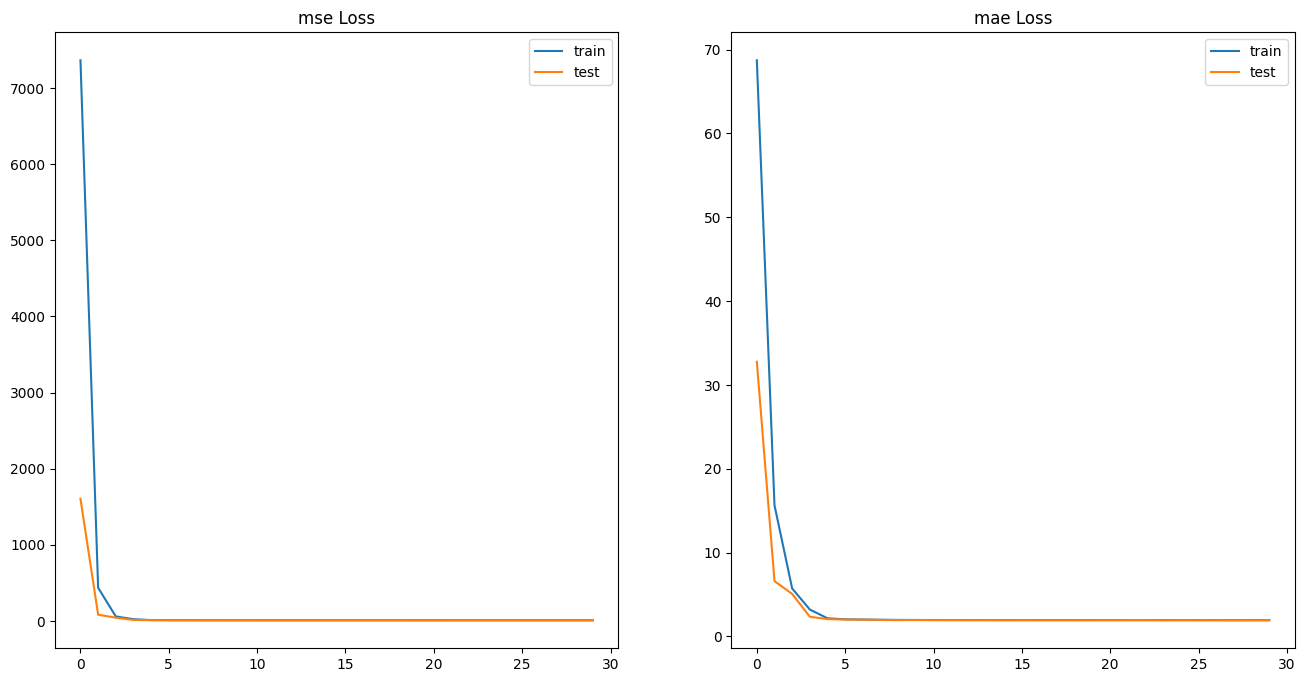

In [25]:
f,a = plt.subplots(1,2,figsize = (16,8))
a[0].plot(train_history,label = 'train')
a[0].plot(valid_history,label = 'test')
a[0].set_title('mse Loss')
a[0].legend()

a[1].plot(train_mae_history,label = 'train')
a[1].plot(valid_mae_history,label = 'test')
a[1].set_title('mae Loss')
a[1].legend()

In [ ]:
# 데이터 많아서 오버피팅도 안된다